# Skin Cancer Classification - Model Training, Validation, and Testing

## **Objective**
This notebook builds and evaluates deep learning models for classifying skin cancer images as **benign** or **malignant**. I will:
1. **Load preprocessed data**
2. **Define and train multiple models**
3. **Compare model performance**
4. **Fine-tune hyperparameters**
5. **Evaluate the final model on the test set**


In [1]:
# General utilities
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pandas as pd
import random


# Deep learning and image processing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K


# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Verify TensorFlow version
print(f"Using TensorFlow version: {tf.__version__}")


Using TensorFlow version: 2.18.0


## Define Dataset Paths

In [2]:
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define dataset paths
base_dir = "/content/drive/MyDrive/CancerCellClassification/dataset/preprocessed/"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Check and print directory structure
def check_directory(directory, name):
    if os.path.exists(directory):
        print(f"{name} Directory Found: {directory}")
    else:
        print(f"Warning: {name} directory not found! Check if validation set exists.")

check_directory(train_dir, "Train")
check_directory(test_dir, "Test")


Train Directory Found: /content/drive/MyDrive/CancerCellClassification/dataset/preprocessed/train
Test Directory Found: /content/drive/MyDrive/CancerCellClassification/dataset/preprocessed/test


### Implement Train-Validation Split

In [4]:
# Define dataset paths
BASE_DIR = "/content/drive/MyDrive/CancerCellClassification/dataset/"
PREPROCESSED_DIR = os.path.join(BASE_DIR, "preprocessed")
FINAL_PROCESSED_DIR = os.path.join(BASE_DIR, "Final_processed")
os.makedirs(FINAL_PROCESSED_DIR, exist_ok=True)  # Ensure folder exists

In [5]:
# Paths for Train and Test from Preprocessed
train_dir = os.path.join(PREPROCESSED_DIR, "train")
test_dir = os.path.join(PREPROCESSED_DIR, "test")

# Paths for Final Processed Datasets
train_data_path = os.path.join(FINAL_PROCESSED_DIR, "train.tfrecord")
val_data_path = os.path.join(FINAL_PROCESSED_DIR, "val.tfrecord")
test_data_path = os.path.join(FINAL_PROCESSED_DIR, "test.tfrecord")

In [8]:
# Check if Final Processed dataset already exists
if os.path.exists(train_data_path) and os.path.exists(val_data_path) and os.path.exists(test_data_path):
    print("Preprocessed dataset found! Loading from Final_processed/...")

    train_data = tf.data.Dataset.load(train_data_path)
    val_data = tf.data.Dataset.load(val_data_path)

    # Load test data separately
    test_images = np.load(test_data_path + "_images.npy")
    test_labels = np.load(test_data_path + "_labels.npy")

else:
    print("No preprocessed dataset found. Processing and saving dataset...")

    # Use `image_dataset_from_directory()` Instead of `ImageDataGenerator`
    validation_split = 0.2  # 80% train, 20% val
    img_size = (224, 224)
    batch_size = 16  # Reduce batch size for faster I/O

    # Load Train Dataset (80%)
    train_data = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset="training",
        seed=42
    )

    # Load Validation Dataset (20%)
    val_data = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset="validation",
        seed=42
    )

    # Load Test Dataset (No Splitting) and Extract Individual Images and Labels
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=img_size,
        batch_size=batch_size
    )

    test_images, test_labels = [], []
    for images_batch, labels_batch in test_dataset:
        test_images.extend(images_batch.numpy())  # Flatten batch structure
        test_labels.extend(labels_batch.numpy())  # Flatten batch structure

    # Convert to NumPy arrays
    test_images = np.array(test_images, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.int32)

    # Optimize Dataset for Faster Training
    AUTOTUNE = tf.data.AUTOTUNE
    train_data = train_data.cache().shuffle(500).prefetch(AUTOTUNE)
    val_data = val_data.cache().prefetch(AUTOTUNE)

    # Save Processed Datasets
    tf.data.Dataset.save(train_data, train_data_path)
    tf.data.Dataset.save(val_data, val_data_path)

    # Save test data separately
    np.save(test_data_path + "_images.npy", test_images)
    np.save(test_data_path + "_labels.npy", test_labels)

    print(f"Train, Val, and Test datasets processed and saved at: {FINAL_PROCESSED_DIR}")


No preprocessed dataset found. Processing and saving dataset...
Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Found 11879 files belonging to 2 classes.
Using 2375 files for validation.
Found 2000 files belonging to 2 classes.
Train, Val, and Test datasets processed and saved at: /content/drive/MyDrive/CancerCellClassification/dataset/Final_processed


- **Train Set:** 9,504 images
- **Validation Set:** 2,375 images (20% of train)
- **Test Set:** 2,000 images (unchanged)
- **Class Labels:**  
  - `Benign`: **0**  
  - `Malignant`: **1**  


### **Visualize Sample Images**
Before moving forward, let’s **visualize some images** from the dataset to ensure everything is loaded correctly.

#### **Display Sample Images from Each Set**

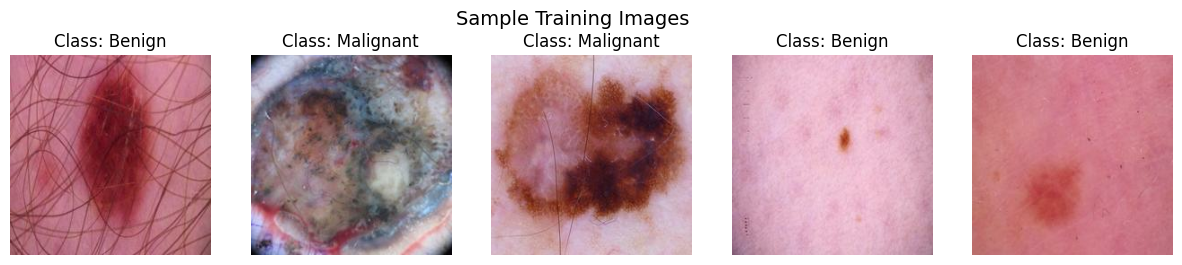

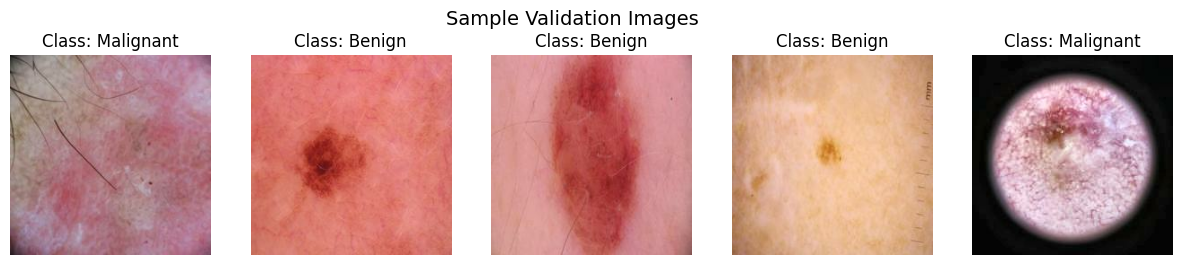

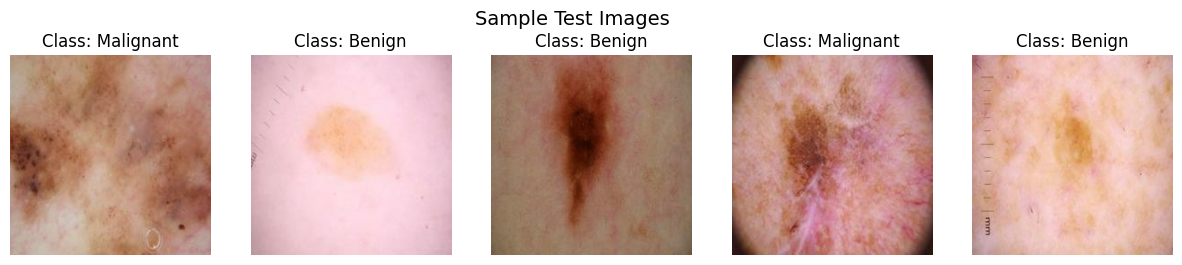

In [20]:
# Function to extract individual images from batched dataset
def extract_samples(dataset, num_samples=5):
    images, labels = [], []

    for img_batch, label_batch in dataset.take(num_samples):
        img = img_batch.numpy()[0]  # Extract only the first image in the batch
        label = label_batch.numpy()[0]  # Extract first label

        images.append(img)
        labels.append(label)

    return images, labels

# Function to visualize images properly
def plot_sample_images(dataset, title, num_images=5, is_numpy=False):
    """Plots images from a dataset.

    Args:
    - dataset: Can be either a TensorFlow dataset (train/val) or a NumPy array (test).
    - title: Title for the plot.
    - num_images: Number of images to display.
    - is_numpy: Set to True if dataset is a NumPy array (test data).
    """
    if is_numpy:
        # Directly use test_data since it's already a NumPy array
        images, labels = test_images[:num_images], test_labels[:num_images]
    else:
        # Extract samples for train/val datasets
        images, labels = extract_samples(dataset, num_images)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        img = images[i]
        label = labels[i]

        # **Fix for Clipping Warning**: Normalize only if max > 1
        if img.max() > 1:
            img = img / 255.0  # Convert from [0,255] to [0,1]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {'Benign' if label == 0 else 'Malignant'}")
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# Display images from train, validation, and test sets
plot_sample_images(train_data, "Sample Training Images")
plot_sample_images(val_data, "Sample Validation Images")
plot_sample_images(test_data, "Sample Test Images", is_numpy=True)  # Test dataset is NumPy


### **Build a Baseline CNN Model**
Now that I have loaded and visualized the data, I will start by defining a **simple baseline CNN model** to establish a performance benchmark.

#### **Define the CNN Model Architecture**
I will use a **Convolutional Neural Network (CNN)** with the following structure:

- **Conv2D Layer 1:** Extracts basic patterns from images.
- **MaxPooling Layer:** Reduces spatial dimensions.
- **Conv2D Layer 2:** Learns more complex features.
- **MaxPooling Layer:** Further reduces dimensions.
- **Flatten Layer:** Converts features into a vector.
- **Fully Connected Dense Layer:** Processes extracted features.
- **Output Layer:** Uses **Softmax activation** for binary classification (Benign/Malignant).

In [21]:
# Define the CNN model
def build_baseline_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Build and summarize the model
baseline_model = build_baseline_model()
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Train the Model**
Now that I have defined our baseline model, let's train it using our prepared dataset.

#### **Train the Model** (Took me about **1.5 hrs** to execute)
I will train the model using the following configurations:
- **Optimizer:** Adam (adaptive learning)
- **Loss Function:** Binary Crossentropy (since this is a binary classification task)
- **Metric:** Accuracy
- **Epochs:** 5 (I initially ran 10, there wasnt much significant change in auracy after 5 epochs )
- **Batch Size:** 32

In [22]:
# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/"
os.makedirs(drive_save_path, exist_ok=True)

In [23]:
# Define base model path
BASE_MODEL_PATH = os.path.join(drive_save_path, 'baseline_model.keras')

# Check if base model already exists
if os.path.exists(BASE_MODEL_PATH):
    print(f"Base model found at {BASE_MODEL_PATH}. Loading existing model...")
    baseline_model = tf.keras.models.load_model(BASE_MODEL_PATH)
else:
    print("Base model not found. Training a new model...")

    # Define training parameters
    epochs = 5
    batch_size = 32

    # Train the base model
    history = baseline_model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Save the trained base model
    baseline_model.save(BASE_MODEL_PATH)
    print(f"Base model trained and saved at {BASE_MODEL_PATH}")


Base model found at /content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/baseline_model.keras. Loading existing model...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
# Load test dataset (ensure it is NumPy)
test_images = np.load(test_data_path + "_images.npy")  # Shape: (2000, 224, 224, 3)
test_labels = np.load(test_data_path + "_labels.npy")  # Shape: (2000,)

# Extract true labels directly
y_true = test_labels  # Already a NumPy array, no need for `.numpy()`

# Get predictions from the baseline model
y_pred_probs = baseline_model.predict(test_images, batch_size=16)  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Compute classification report
report = classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'])
print(report)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
              precision    recall  f1-score   support

      Benign       0.59      0.90      0.71      1000
   Malignant       0.79      0.37      0.51      1000

    accuracy                           0.64      2000
   macro avg       0.69      0.64      0.61      2000
weighted avg       0.69      0.64      0.61      2000



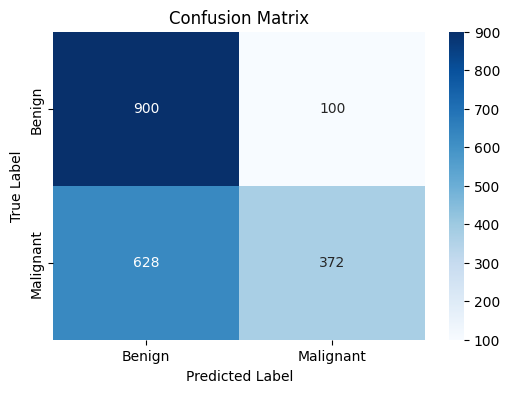

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### **Observations**
- **900** benign cases were correctly classified.
- **372** malignant cases were correctly classified.
- **100** benign cases were misclassified as malignant.
- **628** malignant cases were misclassified as benign.



### **Sample Predictions**

In [27]:
# Function to visualize model predictions with proper image normalization
def plot_model_predictions(model_path, model_name):
    """Loads the model, makes predictions on test images, and plots results."""

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Select random test images
    num_samples = 5
    indices = random.sample(range(len(test_images)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle(f"{model_name} Predictions", fontsize=16)

    for i, idx in enumerate(indices):
        img = test_images[idx]
        true_label = "Benign" if test_labels[idx] == 0 else "Malignant"

        # Preprocess image for model prediction
        img_processed = tf.image.resize(img, [224, 224])  # Ensure correct size
        img_processed = np.expand_dims(img_processed, axis=0)  # Add batch dimension

        # Get prediction
        pred_prob = model.predict(img_processed)[0][0]
        pred_label = "Benign" if pred_prob < 0.5 else "Malignant"

        # **Fix for Clipping Warning** (Ensure values are in [0,255])
        img = np.clip(img, 0, 255).astype(np.uint8)

        # Display image with labels
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")

    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


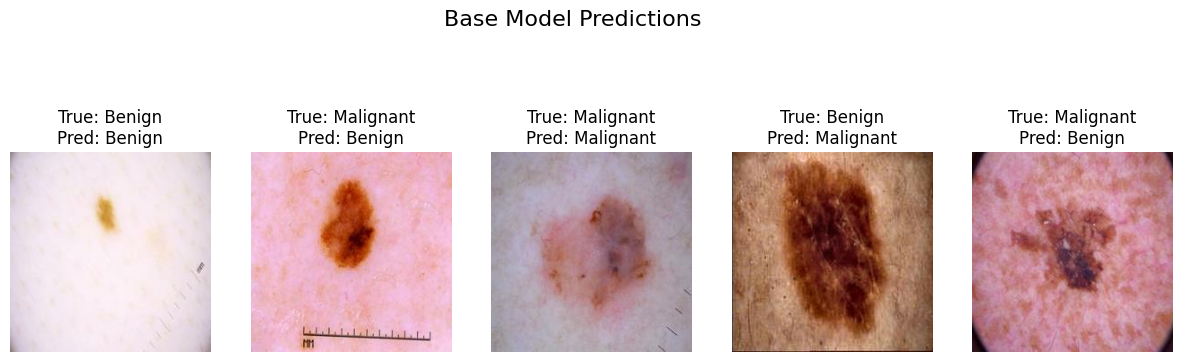

In [28]:
plot_model_predictions(BASE_MODEL_PATH, "Base Model")

### **Observations from Sample Predictions**
- **Correctly Classified Cases**: Some benign and malignant images were predicted correctly, showing that the model has learned distinguishing features.
- **Misclassified Cases**: At least one **benign case was classified as malignant**, which suggests **sensitivity towards malignant features**. While this is better than a false negative (missing a malignant case), it could lead to unnecessary medical interventions.
- The **misclassified benign image appears to have low contrast**, which might have confused the model.




After evaluating the base model's predictions, I are now moving to transfer learning using **pre-trained CNN architectures** (ResNet, EfficientNet, and MobileNet). The goal is to leverage the power of these models, which have been trained on large-scale datasets like ImageNet, and fine-tune them on our **Cancer Cell Classification** task.

---

### **Why Use Transfer Learning?**
1. **Faster Convergence** – Instead of training a CNN from scratch, I use pre-trained feature extractors and only fine-tune the classification layers. This reduces the amount of data and time required for training.
2. **Better Performance** – Pre-trained models have already learned rich hierarchical features (edges, textures, object parts), which generalize Ill to new tasks.
3. **Efficient Resource Utilization** – Training deep models from scratch requires a lot of computational power. By freezing most of the pre-trained layers and training only the classification head, I optimize GPU usage.

---

### **What This Code Does:**
1. **Load the Pre-Trained Base Model**  
   - The previously trained base CNN model (`baseline_model.keras`) is loaded.
   - The layers are frozen (`trainable=False`) to retain the learned features without modifying them.

2. **Define a Transfer Learning Function (`build_transfer_model`)**  
   - The function takes a pre-trained model (EfficientNet, ResNet, or MobileNet).
   - A **Global Average Pooling layer** is added to reduce the spatial dimensions.
   - A **Dense (fully connected) layer** with 128 neurons and ReLU activation is used to introduce new trainable parameters.
   - A **Dropout layer (0.3 probability)** helps prevent overfitting.
   - A **Sigmoid output layer** is added to classify images into two categories: Benign (0) or Malignant (1).

3. **Loop Through Pre-Trained Models**  
   - Three pre-trained models (**ResNet, EfficientNet, MobileNet**) are initialized without the final classification layers (`include_top=False`).
   - For each model:
     - A new classification head is added using `build_transfer_model`.
     - The model is compiled with the **Adam optimizer** and **binary cross-entropy loss**.
     - The model is trained on the **cancer cell dataset** for **3 epochs** with a batch size of **8** to balance memory usage.
     - The trained model is saved in Google Drive (`CancerModelCheckpoints`).
     - The training history (accuracy, loss, validation accuracy) is saved as a `.csv` file for later visualization.

4. **Memory Optimization**  
   - After training each model:
     - The model is **deleted from memory (`del model`)**.
     - **Garbage collection (`gc.collect()`)** is used to free up GPU/CPU memory.
     - **Keras backend session is cleared (`tf.keras.backend.clear_session()`)** to prevent memory leaks.


In [29]:
# Function to build transfer learning models
def build_transfer_model(base_model):
    """Adds a classification head on top of a pre-trained model."""
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)
    return Model(inputs=base_model.input, outputs=output)

In [30]:
# Define model paths
model_paths = {
    "ResNet": os.path.join(drive_save_path, "ResNet.keras"),
    "EfficientNet": os.path.join(drive_save_path, "EfficientNet.keras"),
    "MobileNet": os.path.join(drive_save_path, "MobileNet.keras")
}

# Dictionary to store models
models = {}

# Load existing models if available
for name, path in model_paths.items():
    if os.path.exists(path):
        print(f"Loading {name} model from {path}...")
        models[name] = tf.keras.models.load_model(path)
    else:
        print(f"{name} model not found at {path}. It will be trained.")

Loading ResNet model from /content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/ResNet.keras...
Loading EfficientNet model from /content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/EfficientNet.keras...
Loading MobileNet model from /content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/MobileNet.keras...


In [31]:
# Define models for transfer learning
pretrained_models = {
    "ResNet": ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "EfficientNet": EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "MobileNet": MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
}



In [32]:
# Training loop - train only if model is missing
history_logs = {}

for name, pretrained_model in pretrained_models.items():
    model_save_path = model_paths[name]
    history_csv_path = os.path.join(drive_save_path, f"{name}_history.csv")

    # Skip training if model already exists
    if name in models:
        print(f"{name} model already exists. Skipping training...")
        continue

    print(f"\nTraining {name}...")

    # Build and compile the model
    model = build_transfer_model(pretrained_model)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=3,  # Reduce epochs for fast results
        batch_size=8,  # Smaller batch size to avoid memory issues
        verbose=1
    )

    # Save trained model
    model.save(model_save_path)
    print(f"{name} training completed. Model saved at: {model_save_path}")

    # Save history logs (accuracy, loss, validation accuracy, etc.)
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_csv_path, index=False)
    history_logs[name] = history_df
    print(f"Training log saved at: {history_csv_path}")

    # Clear memory after training each model
    del model
    gc.collect()
    tf.keras.backend.clear_session()

print("All models trained or loaded successfully!")


ResNet model already exists. Skipping training...
EfficientNet model already exists. Skipping training...
MobileNet model already exists. Skipping training...
All models trained or loaded successfully!


### **Model Training Performance**
I successfully trained **three deep learning models** for skin cancer classification:  
1. **ResNet50**
   - **Final Accuracy**: **87.98%**
   - **Final Validation Accuracy**: **85.85%**
   - **Observations**: Performance improved steadily, but validation loss fluctuated slightly.
   
2. **EfficientNetB0**
   - **Final Accuracy**: **92.96%**
   - **Final Validation Accuracy**: **90.99%**
   - **Observations**: Achieved the highest validation accuracy with the loIst loss, making it the most stable model.

3. **MobileNetV2**
   - **Final Accuracy**: **90.07%**
   - **Final Validation Accuracy**: **88.04%**
   - **Observations**: Started slow but caught up, although its validation loss was higher than EfficientNet.


### **Evaluate Models on Test Data**



In [34]:
# Load test dataset (ensure it is NumPy)
test_images = np.load(test_data_path + "_images.npy")  # Shape: (2000, 224, 224, 3)
test_labels = np.load(test_data_path + "_labels.npy")  # Shape: (2000,)

# Extract true labels directly from test_labels
y_true = test_labels  # No need for `.numpy()`

# Fix dataset batching
batch_size = 16

# Evaluate models
for name, model_path in model_paths.items():
    print(f"\nEvaluating {name} on test dataset...\n")

    # Load model
    model = tf.keras.models.load_model(model_path)

    # Ensure test data is properly formatted for prediction
    test_data_fixed = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

    # Get predictions
    y_pred_probs = model.predict(test_data_fixed, batch_size=batch_size)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    # Compute classification report
    report = classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'])
    print(f"\n{name} Classification Report:\n")
    print(report)



Evaluating ResNet on test dataset...

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

ResNet Classification Report:

              precision    recall  f1-score   support

      Benign       0.72      0.98      0.83      1000
   Malignant       0.98      0.61      0.75      1000

    accuracy                           0.80      2000
   macro avg       0.85      0.80      0.79      2000
weighted avg       0.85      0.80      0.79      2000


Evaluating EfficientNet on test dataset...

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step

EfficientNet Classification Report:

              precision    recall  f1-score   support

      Benign       0.89      0.94      0.92      1000
   Malignant       0.94      0.89      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000


Evaluating MobileNet on test dataset...

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step

MobileNet Classificat

### **Plot Model Performance**
#### **Accuracy & Loss Curves**

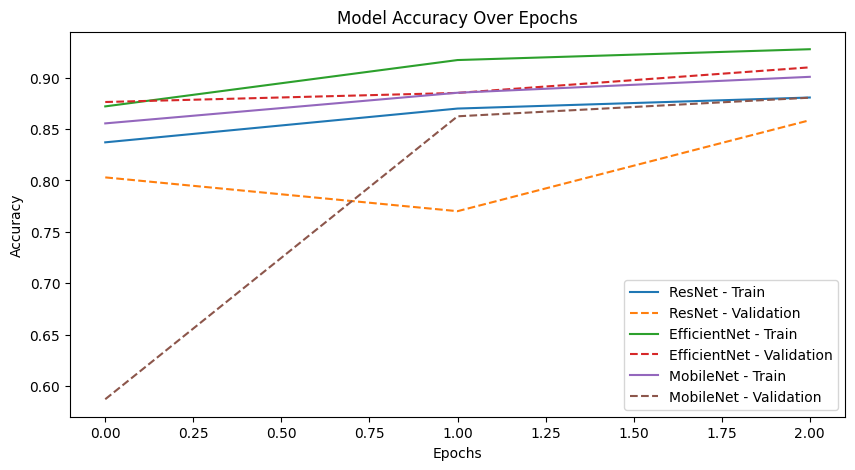

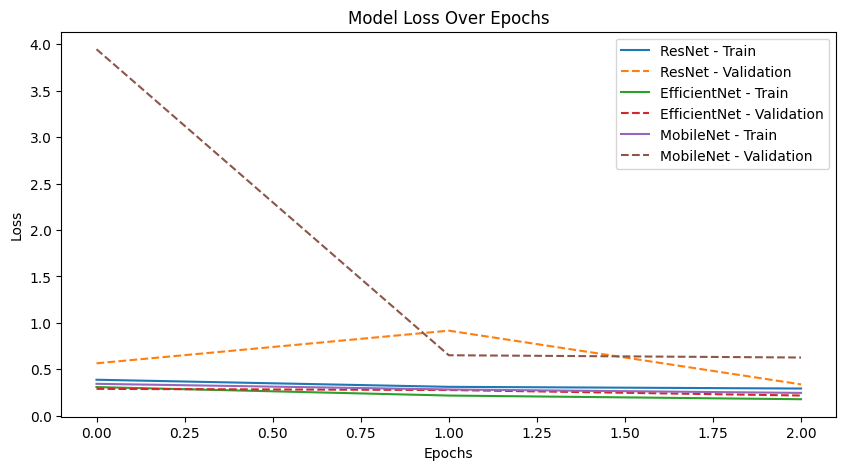

In [35]:
# Define paths to training logs
history_paths = {
    "ResNet": "/content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/ResNet_history.csv",
    "EfficientNet": "/content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/EfficientNet_history.csv",
    "MobileNet": "/content/drive/MyDrive/CancerCellClassification/CancerModelCheckpoints/MobileNet_history.csv",
}

# Load training histories
histories = {name: pd.read_csv(path) for name, path in history_paths.items()}

# Plot accuracy curves
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    plt.plot(history["accuracy"], label=f"{name} - Train")
    plt.plot(history["val_accuracy"], label=f"{name} - Validation", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    plt.plot(history["loss"], label=f"{name} - Train")
    plt.plot(history["val_loss"], label=f"{name} - Validation", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

### Explanation of the Plots

These plots illustrate the performance of the three models (ResNet, EfficientNet, and MobileNet) over the training epochs.

#### **1. Model Accuracy Over Epochs**

#### **Key Observations:**
- **EfficientNet (Green - Solid & Dashed)** has the highest training and validation accuracy, indicating that it performs Ill on both seen (train) and unseen (validation) data.
- **ResNet (Blue - Solid & Dashed)** shows steady improvement, but its validation accuracy is lower than its training accuracy. This suggests potential overfitting.
- **MobileNet (Brown - Solid & Dashed)** has a steep improvement in validation accuracy from epoch 0 to 1 but then stabilizes. Its performance fluctuates the most.

#### **2. Model Loss Over Epochs**

#### **Key Observations:**
- **MobileNet (Brown - Dashed)** starts with a **very high validation loss** (~4.0) at epoch 0 but drops significantly by epoch 1. This means its initial predictions were very poor, but it quickly improved.
- **EfficientNet (Green - Solid & Dashed)** has the lowest loss among all models, reinforcing that it's performing best overall.
- **ResNet (Blue - Solid & Dashed)** has a moderate loss, showing that it's making some errors but is still improving.

### **Final Takeaways:**
- **EfficientNet is the best model**, achieving high accuracy with low loss.
- **ResNet shows signs of overfitting** (training accuracy is much higher than validation accuracy).
- **MobileNet improved significantly after the first epoch but had a high initial loss**, indicating that it needed more training time.

#### **Confusion Matrix**


Evaluating ResNet on test dataset...

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

Evaluating EfficientNet on test dataset...

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step

Evaluating MobileNet on test dataset...

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


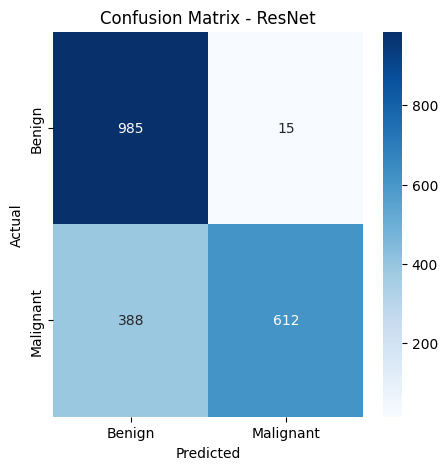

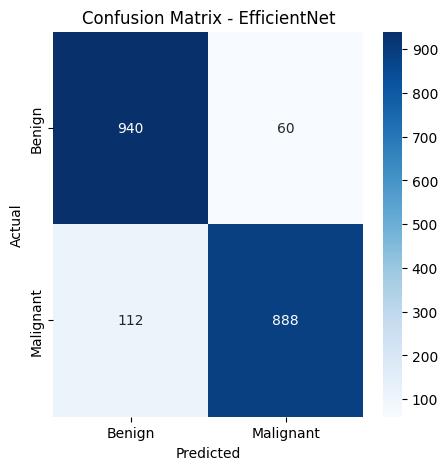

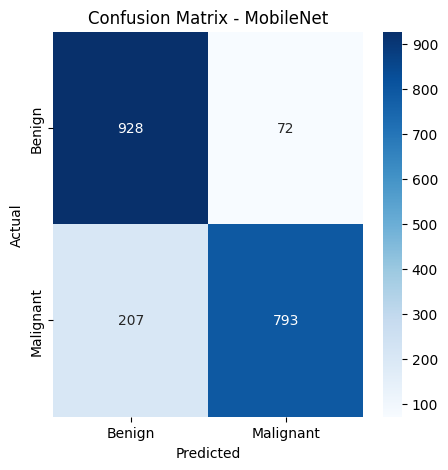

In [37]:
# Initialize dictionary to store predictions for each model
y_pred = {}

# Evaluate models
for name, model_path in model_paths.items():
    print(f"\nEvaluating {name} on test dataset...\n")

    # Load model
    model = tf.keras.models.load_model(model_path)

    # Ensure test data is properly formatted for prediction
    test_data_fixed = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

    # Get predictions and store them in dictionary
    y_pred_probs = model.predict(test_data_fixed, batch_size=batch_size)
    y_pred[name] = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Generate Confusion Matrices
for name in y_pred.keys():  # Ensure `y_pred` is a dictionary
    cm = confusion_matrix(y_true, y_pred[name])

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


#### **ROC Curve**

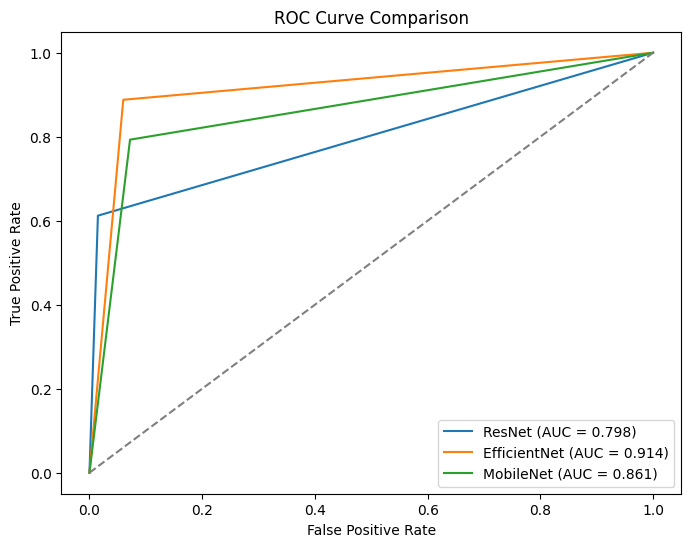

In [38]:
plt.figure(figsize=(8, 6))

for name in models.keys():
    fpr, tpr, _ = roc_curve(y_true, y_pred[name])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="dashed", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()


#### **Key Observations**
- **EfficientNet has the steepest rise**, indicating that it achieves a high **true positive rate** with a lower **false positive rate**, which is ideal for medical applications.
- **MobileNet is slightly worse than EfficientNet but still significantly better than ResNet**.
- **ResNet has the weakest performance**, as it does not separate the classes as effectively as the other two models.



### **Conclusion**
- **EfficientNet is the best model** for this classification task, as it achieves the highest AUC.
- **MobileNet is a close second** and can still be considered a good alternative.
- **ResNet underperforms compared to the others**, so it may require hyperparameter tuning or further training.